In [1]:
import torch
from torch import nn
from torchvision import datasets,transforms,models

import matplotlib.pyplot as plt
from pathlib import Path
from helper_functions import download_data
from engine import train
from data_setup import create_dataloaders
from utils import save_model
import pandas as pd
from timeit import default_timer as timer
import random

from PIL import Image

2.6.0+cu124 True


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
effnetb2_file_path = Path("models/effnetb2_pizza_steak_sushi.pt")
effnetb2 = models.efficientnet_b2(weights=None)  

for param in effnetb2.parameters():
    param.requires_grad = False
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1408,out_features=3)
)
effnetb2.load_state_dict(torch.load(f=effnetb2_file_path))
effnetb2.to(device=device)
effnetb2_transforms = models.EfficientNet_B2_Weights.DEFAULT.transforms

In [4]:
data_path = Path("data/pizza_steak_sushi_20_percent/")
train_dir = data_path / "train"
test_dir = data_path / "test"

In [5]:
train_dataloader_effnetb2,test_dataloader_effnetb2,class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [6]:
class_names

['pizza', 'steak', 'sushi']

In [24]:
def predict_image(img, model, transforms):
    
    start_time = timer()
    
    # Create transform object and apply it to the image
    transform = transforms()
    img = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim=1)
    
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    pred_time = round(timer() - start_time, 5)
    
    return pred_labels_and_probs, pred_time

In [14]:
test_image_dir = list(Path(test_dir).glob("*/*.jpg"))
random_image = Image.open(random.sample(test_image_dir,k=1)[0])


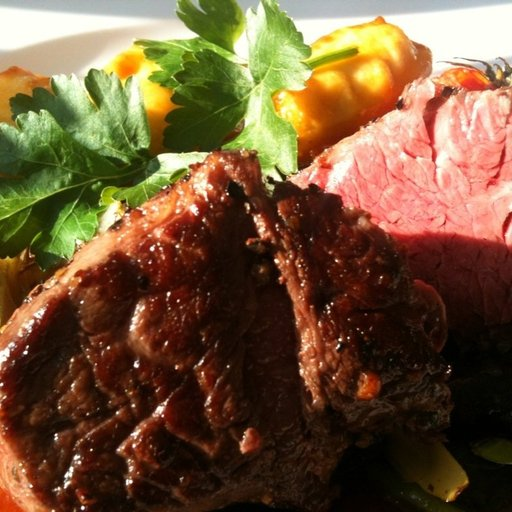

In [15]:
random_image

In [18]:
effnetb2_prediction,effnetb2_prediction_time = predict_image(random_image,effnetb2,effnetb2_transforms)

effnetb2_prediction,sorted(effnetb2_prediction.items(),key=lambda x:x[1])[-1]

({'pizza': 0.062406476587057114,
  'steak': 0.8235872387886047,
  'sushi': 0.11400629580020905},
 ('steak', 0.8235872387886047))

In [19]:
example_list = [(str(file)) for file in  random.sample(test_image_dir,k=5)]
example_list

['data/pizza_steak_sushi_20_percent/test/steak/66858.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/730464.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg']

In [26]:
import gradio as gr


title = "Pizza Steak Sushi"
description = "Hello There"
article="trying out gradio"

demo = gr.Interface(
    fn=lambda img: predict_image(img, effnetb2, effnetb2_transforms),
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=3,label="Predictions"),
        gr.Number(label="Time(s)")
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

demo.launch(
    debug=False,
    share=True
)

* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://6e8e4c28f8351735ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
